### Under the Hood

NOTE: In this section the bias term will be called $b$, and the feature weights vector will be called $w$. No bias feature will be added to the input feature vectors

The Linear SVM classifier model predicts the class of a new instance $x$ by simply computing the decision function
$$
w^Tx+b=w_{1}x_{1}+\dots+w_{n}x_{n}+b$$
If the result is positive, the predicted class $\hat{y}$ is the positive class, and otherwise it is the negative class

\begin{cases}
  0 \text{ if } w^{T}x+b < 0 \\
  1 \text{ if } w^{T}x+b \geq 0
\end{cases}


In [1]:
from sklearn import datasets

iris = datasets.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
	x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
	X_crop = X[x1_in_bounds]
	y_crop = y[x1_in_bounds]
	x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
	x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
	x1, x2 = np.meshgrid(x1s, x2s)
	xs = np.c_[x1.ravel(), x2.ravel()]
	df = (xs.dot(w) + b).reshape(x1.shape)
	m = 1 / np.linalg.norm(w)
	boundary_x2s = -x1s * (w[0] / w[1]) - b / w[1]
	margin_x2s_1 = -x1s * (w[0] / w[1]) - (b - 1) / w[1]
	margin_x2s_2 = -x1s * (w[0] / w[1]) - (b + 1) / w[1]
	ax.plot_surface(x1s, x2, np.zeros_like(x1),
					color="b", alpha=0.2, cstride=100, rstride=100)
	ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
	ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
	ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
	ax.plot(X_crop[:, 0][y_crop == 1], X_crop[:, 1][y_crop == 1], 0, "g^")
	ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
	ax.plot(X_crop[:, 0][y_crop == 0], X_crop[:, 1][y_crop == 0], 0, "bs")
	ax.set_xlim(x1_lim)
	ax.set_ylim(x2_lim)
	ax.set_zlim([df.min(), df.max()])
	ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
	ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
	ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
	ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
	ax.legend(loc="upper left", fontsize=16)



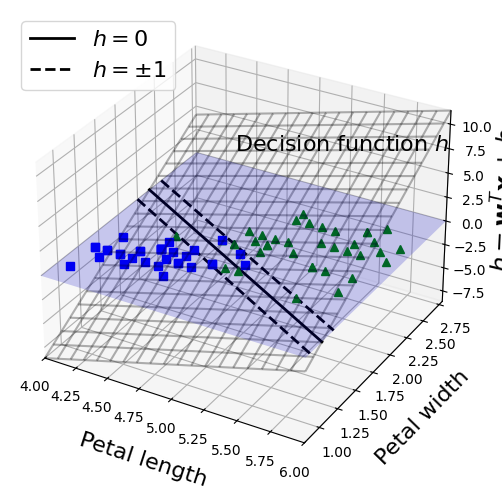

In [3]:
%matplotlib inline
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
svm_clf = LinearSVC(C=100, dual=True, loss="hinge", random_state=42, max_iter=10000)

scaled_svm_clf = make_pipeline(scaler, svm_clf)
scaled_svm_clf.fit(X, y)

b = svm_clf.decision_function([-scaler.mean_ / scaler.scale_])
w = svm_clf.coef_[0] / scaler.scale_
svm_clf.intercept_ = np.array([b])
svm_clf.coef_ = np.array([w])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx2 = (t * (X.dot(w) + b) < 1).to_numpy().ravel()
svm_clf.support_vectors_ = X[support_vectors_idx2]

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection="3d")
plot_3D_decision_function(ax1, w=svm_clf.coef_[0], b=svm_clf.intercept_[0])
plt.show()

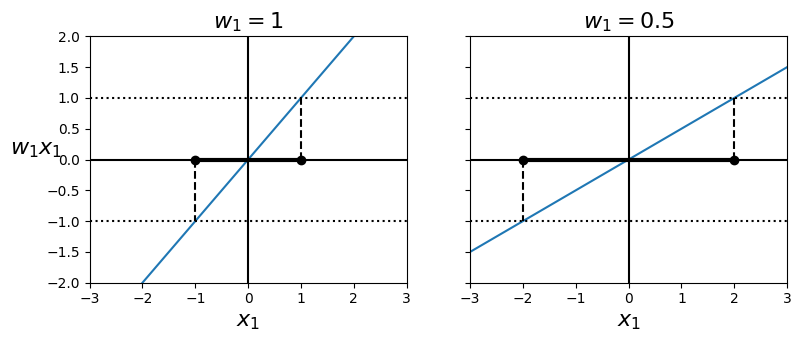

In [4]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
	x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
	y = w * x1 + b
	m = 1 / w

	plt.plot(x1, y)
	plt.plot(x1_lim, [1, 1], "k:")
	plt.plot(x1_lim, [-1, -1], "k:")
	plt.axhline(y=0, color='k')
	plt.axvline(x=0, color='k')
	plt.plot([m, m], [0, 1], "k--")
	plt.plot([-m, -m], [0, -1], "k--")
	plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
	plt.axis(x1_lim + [-2, 2])
	plt.xlabel(r"$x_1$", fontsize=16)
	if ylabel:
		plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
	plt.title(r"$w_1 = {}$".format(w), fontsize=16)


fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
plt.show()

### Hard margin linear SVM classifier

So we want to minimize $||w||$ to get a large margin. If we also want to avoid any margin violations (hard margin), then we need the decision function to be greater than 1 for all positive training instances and lower than -1 for negative training instances. If we define $t^{(i)}=-1$ for negative instances (if $y^{(i)}=0$) and $t^{(i)}=1$ for positive instances (if $y^{(i)}=1$), then we can express this constraint as $t^{(i)}(w^{T}x^{(i)} + +b)\geq1$ for all instances


We can therefore express the hard margin linear SVM classifier objective as the constrained optimization problem:

\begin{align*}
\min_{\mathbf{w}, b} \quad & \frac{1}{2} \mathbf{w}^\top \mathbf{w} \\
\text{subject to} \quad & t^{(i)} \left( \mathbf{w}^\top \mathbf{x}^{(i)} + b \right) \geq 1 \quad \text{for } i = 1, 2, \dots, m
\end{align*}


### Soft margin linear SVM classifier

To get the soft margin objective, we need to introduce a slack variable $\zeta^{(i)}\geq 0$ for each instance. $zeta^{(i)}$ measures how much the $i^{th}$ instance is allowed to violate the margin. We now have two conflicting objectives: make the slack variables as small as possible to reduce the margin violations, and make $frac{1}{2}w^{T}w$ as small as possible to increase the margin. This is where the $C$ hyperparameter comes in: it allows us to define the trade-off between these two objectives. This gives us the constrained optimization problem:

\begin{align*}
\min_{\mathbf{w}, b, \boldsymbol{\zeta}} \quad & \frac{1}{2} \mathbf{w}^\top \mathbf{w} + C \sum_{i=1}^{m} \zeta^{(i)} \\
\text{subject to} \quad & t^{(i)} (\mathbf{w}^\top \mathbf{x}^{(i)} + b) \geq 1 - \zeta^{(i)} \quad \text{and} \quad \zeta^{(i)} \geq 0 \quad \text{for } i = 1, 2, \dots, m
\end{align*}


## Quadratic Programming Formulation

The hard margin and soft margin problems are both convex quadratic optimization problems with linear constraints. Such problems are known as Quadratic Programming (QP) problems. Many off-the-shelf solvers are available to solve QP problems using a variety of techniques.

The general problem formulation is given by:

\[
\begin{aligned}
&\begin{array}{ll}
\underset{\mathbf{p}}{\operatorname{Minimize}} & \frac{1}{2} \mathbf{p}^{\top} \mathbf{H} \mathbf{p} + \mathbf{f}^{\top} \mathbf{p} \\
\text{subject to} & \mathbf{A} \mathbf{p} \leq \mathbf{b}
\end{array} \\
&\text{where} \quad
\begin{cases}
\mathbf{p} & \text{is an } n_p\text{-dimensional vector } (n_p = \text{number of parameters}), \\
\mathbf{H} & \text{is an } n_p \times n_p \text{ matrix}, \\
\mathbf{f} & \text{is an } n_p\text{-dimensional vector}, \\
\mathbf{A} & \text{is an } n_c \times n_p \text{ matrix } (n_c = \text{number of constraints}), \\
\mathbf{b} & \text{is an } n_c\text{-dimensional vector}.
\end{cases}
\end{aligned}
\]

Note that the expression $\mathbf{A} \mathbf{p} \leq \mathbf{b}$ defines $n_c$ constraints: $\mathbf{p}^{\top} \mathbf{a}^{(i)} \leq b^{(i)}$ for $i = 1, 2, \dots, n_c$, where $\mathbf{a}^{(i)}$ is the $i^{\text{th}}$ row of $\mathbf{A}$ and $b^{(i)}$ is the $i^{\text{th}}$ element of $\mathbf{b}$.

We can verify that if we set the QP parameters in the following way, we get the hard margin linear SVM classifier objective:

- $n_p = n + 1$, where $n$ is the number of features (the $+1$ is for the bias term),
- $n_c = m$, where $m$ is the number of training instances,
- $\mathbf{H}$ is the $n_p \times n_p$ identity matrix, except with a zero in the last row and column (to ignore the bias term),
- $\mathbf{f} = \mathbf{0}$, an $n_p$-dimensional vector of zeros,
- $\mathbf{b} = -\mathbf{1}$, an $n_c$-dimensional vector of $-1$s,
- $\mathbf{a}^{(i)} = -t^{(i)} \tilde{\mathbf{x}}^{(i)}$, where $\tilde{\mathbf{x}}^{(i)}$ is $\mathbf{x}^{(i)}$ with an extra bias feature $\dot{x}_{0}=1$

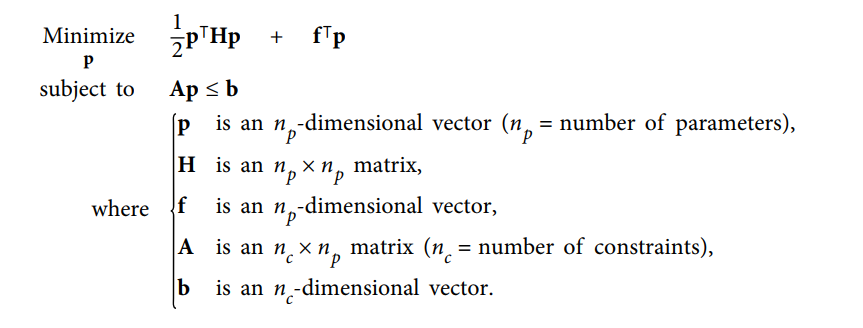

## The Dual Problem

To use the kernel trick, we are going to look at a different constrained optimization problem.

Given a constrained Optimization problem, known as the primal problem, it is possible to express a different but closely related problem ,called its dual problem. The solution to the dual problem typically gives a lower bound to the solution of the primal problem, but under some conditions it can have the same solution as the primal problem. Luckily, the SVM problem happens to meet these conditions, so you can choose to solve the primal problem or the dual problem; both will have the same solution. Equation below shows the dual from of the linear SVM objective:

\begin{array}{r}
\underset{\alpha}{\operatorname{minimize}} \frac{1}{2} \sum_{i=1}^m \sum_{j=1}^m \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)} \mathbf{x}^{(i) \top} \mathbf{x}^{(j)}-\sum_{i=1}^m \alpha^{(i)} \\
\text { subject to } \alpha^{(i)} \geq 0 \text { for } i=1,2, \cdots, m
\end{array}

Once you find the vector $\widehat{\alpha}$ that minimizes this equation (using a QP solver), use it in further equation to compute $\widehat{\mathbf{w}}$ and $\hat{b}$ that minimize the primal problem.
$$
\begin{aligned}
& \widehat{\mathbf{w}}=\sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} \mathbf{x}^{(i)} \\
& \hat{b}=\frac{1}{n_s} \sum_{\substack{i=1 \\
\hat{\alpha}^{(i)}>0}}^m\left(t^{(i)}-\widehat{\mathbf{w}}^{\top} \mathbf{x}^{(i)}\right)
\end{aligned}
$$

The dual problem is faster to solve than the primal one when the number of training instances is smaller than the number of features. More importantly, the dual problem makes the kernel trick possible, while the primal doesn't. So what is this kernel trick?


## Kernelized SVMs

Suppose you want to apply a second-degree polynomial transformation to a two-dimensional training set (such as moons training set), then train a linear SVM classifier on the transformed training set. Equation below shows the second-degree polynomial mapping function $\phi$ that you want to apply

$$
\phi(\mathbf{x})=\phi\left(\binom{x_1}{x_2}\right)=\left(\begin{array}{c}
x_1^2 \\
\sqrt{2} x_1 x_2 \\
x_2^2
\end{array}\right)
$$

Notice that the transformed vector is 3D instead of 2D. Now let's look at what happens to a couple of 2D vectors, $\mathbf{a}$ and $\mathbf{b}$, if we apply this second-degree polynomial mapping and then compute the dot product ${ }^7$ of the transformed vectors
$$
\begin{aligned}
\phi(\mathbf{a})^{\top} \phi(\mathbf{b}) & =\left(\begin{array}{c}
a_1^2 \\
\sqrt{2} a_1 a_2 \\
a_2^2
\end{array}\right)^{\top}\left(\begin{array}{c}
b_1^2 \\
\sqrt{2} b_1 b_2 \\
b_2^2
\end{array}\right)=a_1^2 b_1^2+2 a_1 b_1 a_2 b_2+a_2^2 b_2^2 \\
& =\left(a_1 b_1+a_2 b_2\right)^2=\left(\binom{a_1}{a_2}^{\top}\binom{b_1}{b_2}\right)^2=\left(\mathbf{a}^{\top} \mathbf{b}\right)^2
\end{aligned}
$$

How about that? The dot product of the transformed vectors is equal to the squared of the dot product of the original vectors: $\phi(\mathbf{a})^{\top} \phi(\mathbf{b}) = (\mathbf{a}^{\top} \mathbf{b})^2$.

Here is the key insight: if you apply the transformation $\phi$ to all training instances, then the dual problem will contain the dot product $\phi(\mathbf{x}^{(i)})^{\top} \phi(\mathbf{x}^{(j)})$, But if $\phi$ is the second-degree polynomial transformation defined above, then you can replace this dot product of transformed vectors simply by $(\mathbf{x}^{(i)})^{\top} \mathbf{x}^{(j})^2$. So you don't need to transform the training instances at all; just replace the dot product by its squared values. The result will be strictly the same as if you had gone through the trouble of transforming the training set then fitting linear SVM algorithm, but this trick makes the whole process much more computationally efficient.

The function $K(\mathbf{a}^{(i)}, \mathbf{b}^{(j)}) = \phi(\mathbf{a}^{(i)})^{\top} \phi(\mathbf{b}^{(j)})$  is a second-degree polynomial kernel. In Machine Learning, a kernle is a function capable of computing the dot product $\phi(\mathbf{a}^{(i)})^{\top} \phi(\mathbf{b}^{(j)})$ based only on the original vectors $\mathbf{a}$ and $\mathbf{b}$, without having to copmute the transformation $\phi$ explicitly.


### Common Kernels:

- **Linear kernel**: $K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^{\top} \mathbf{b}$
- **Polynomial kernel**: $K(\mathbf{a}, \mathbf{b}) = (\mathbf{a}^{\top} \mathbf{b} + c)^d$, where $c$ is a constant and $d$ is the degree of the polynomial
- **Gaussian (RBF) k`ernel**: $K(\mathbf{a}, \mathbf{b}) = \exp\left(-\frac{||\mathbf{a} - \mathbf{b}||^2}{2\sigma^2}\right)$, where $\sigma$ is a hyperparameter that controls the width of the Gaussian
- **Sigmoid kernel**: $K(\mathbf{a}, \mathbf{b}) = \tanh\left(\kappa \mathbf{a}^{\top} \mathbf{b} + c\right)$, where $\kappa$ and $c$ are hyperparameters


### Predictions with a kernelized SVM classifier
To make the predictions we can plug the formula for $\hat{w}$ into from the dual solution to the primal solution into the decision function for a new instance $x^{(n)}$, and you get an equation with only dot products between input vectors. This makes it possible to use the kernel trick

$$
\begin{aligned}
h_{\widehat{\mathbf{w}}, \hat{b}}\left(\phi\left(\mathbf{x}^{(n)}\right)\right)= & \widehat{\mathbf{w}}^{\top} \phi\left(\mathbf{x}^{(n)}\right)+\hat{b}=\left(\sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} \phi\left(\mathbf{x}^{(i)}\right)\right)^{\top} \phi\left(\mathbf{x}^{(n)}\right)+\hat{b} \\
= & \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)}\left(\phi\left(\mathbf{x}^{(i)}\right)^{\top} \phi\left(\mathbf{x}^{(n)}\right)\right)+\hat{b} \\
= & \sum_{i=1}^m \hat{\alpha}^{(i)} t^{(i)} K\left(\mathbf{x}^{(i)}, \mathbf{x}^{(n)}\right)+\hat{b} \\
& \hat{\alpha}^{(i)}>0
\end{aligned}
$$

Note that since $\alpha^{(i)} \neq 0$ only for support vectors, making predictions involves computing the dot product of the new input vector $\mathbf{x}^{(n)}$ with only the support vectors, not all the training instances. Of course, you need to use the same trick to compute the bias term $\hat{b}$

$$
\begin{aligned}
\hat{b} & =\frac{1}{n_s} \sum_{\substack{i=1 \\
\hat{\alpha}^{(i)}>0}}^m\left(t^{(i)}-\widehat{\mathbf{w}}^{\top} \phi\left(\mathbf{x}^{(i)}\right)\right)=\frac{1}{n_s} \sum_{\substack{i=1 \\
\hat{\alpha}^{(i)}>0}}^m\left(t^{(i)}-\left(\sum_{j=1}^m \hat{\alpha}^{(j)} t^{(j)} \phi\left(\mathbf{x}^{(j)}\right)\right)^{\top} \phi\left(\mathbf{x}^{(i)}\right)\right) \\
& =\frac{1}{n_s} \sum_{\substack{i=1 \\
\hat{\alpha}^{(i)}>0}}^m\left(t^{(i)}-\sum_{\substack{j=1 \\
\hat{\alpha}^{(j)}>0}}^m \hat{\alpha}^{(j)} t^{(j)} K\left(\mathbf{x}^{(i)}, \mathbf{x}^{(j)}\right)\right)
\end{aligned}
$$

### Linear SVM classifier implementation using Batch Gradient Descent

In [5]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 2)

In [6]:
from sklearn.base import BaseEstimator


class MyLinearSVC(BaseEstimator):
	def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
		self.intercept_ = None
		self.coef_ = None
		self.support_vectors_ = None
		self.Js = None

		self.C = C
		self.eta0 = eta0
		self.eta_d = eta_d
		self.n_epochs = n_epochs
		self.random_state = random_state

	def eta(self, epoch):
		return self.eta0 / (epoch + self.eta_d)

	def fit(self, X, y):
		if self.random_state:
			np.random.seed(self.random_state)

		w = np.random.randn(X.shape[1], 1)  # n feature weights
		b = 0

		t = np.array(y, dtype=np.float64).reshape(-1, 1) * 2 - 1
		X_t = X * t
		self.Js = []

		# Training
		for epoch in range(self.n_epochs):
			support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
			X_t_sv = X_t[support_vectors_idx]
			t_sv = t[support_vectors_idx]

			J = 1 / 2 * (w * w).sum() + self.C * ((1 - X_t_sv.dot(w)).sum() - b * t_sv.sum())

			self.Js.append(J)

			w_gradient_vector = w - self.C * X_t_sv.sum(axis=0).reshape(-1, 1)
			b_derivative = -self.C * t_sv.sum()

			w = w - self.eta(epoch) * w_gradient_vector.reshape(-1, 1)
			b = b - self.eta(epoch) * b_derivative

		self.intercept_ = np.array([b])
		self.coef_ = np.array([w])
		support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
		self.support_vectors_ = X[support_vectors_idx]

	def decision_function(self, X):
		return X.dot(self.coef_[0]) + self.intercept_[0]

	def predict(self, X):
		return self.decision_function(X) >= 0

In [7]:
C = 2
svm_clf = MyLinearSVC(C=C, eta0=10, eta_d=1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[ True],
       [False]])

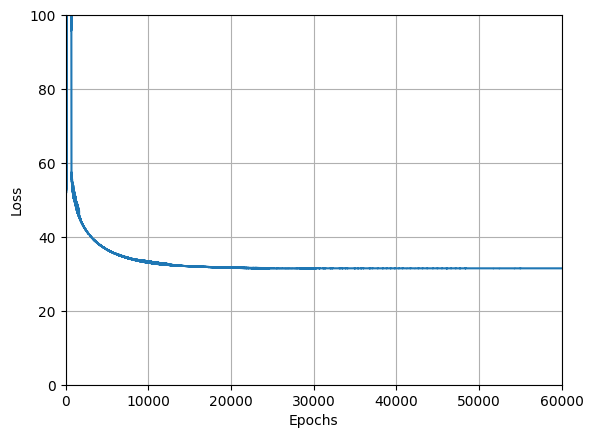

In [8]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [9]:
svm_clf.intercept_, svm_clf.coef_


(array([-15.56761653]),
 array([[[2.28120287],
         [2.71621742]]]))

In [10]:
from sklearn.svm import SVC

svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.to_numpy().ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


In [11]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
	w = svm_clf.coef_[0]
	b = svm_clf.intercept_[0]

	# At the decision boundary, w0*x0 + w1*x1 + b = 0
	# => x1 = -w0/w1 * x0 - b/w1
	x0 = np.linspace(xmin, xmax, 200)
	decision_boundary = -w[0] / w[1] * x0 - b / w[1]

	margin = 1 / w[1]
	gutter_up = decision_boundary + margin
	gutter_down = decision_boundary - margin
	svs = svm_clf.support_vectors_

	plt.plot(x0, decision_boundary, "k-", linewidth=2, zorder=-2)
	plt.plot(x0, gutter_up, "k--", linewidth=2, zorder=-2)
	plt.plot(x0, gutter_down, "k--", linewidth=2, zorder=-2)
	plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#AAA',
				zorder=-1)

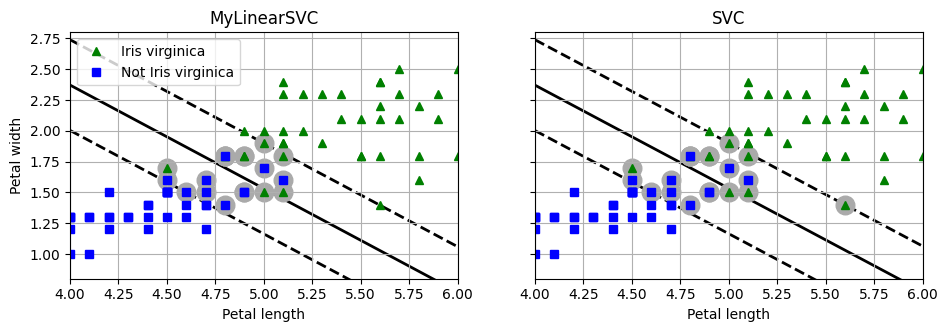

In [12]:
yr = y.to_numpy().ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr == 1], X[:, 1][yr == 1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr == 0], X[:, 1][yr == 0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("MyLinearSVC")
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")
plt.grid()

plt.sca(axes[1])
plt.plot(X[:, 0][yr == 1], X[:, 1][yr == 1], "g^")
plt.plot(X[:, 0][yr == 0], X[:, 1][yr == 0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length")
plt.title("SVC")
plt.axis([4, 6, 0.8, 2.8])
plt.grid()

plt.show()

[-12.52988101   1.94162342   1.84544824]


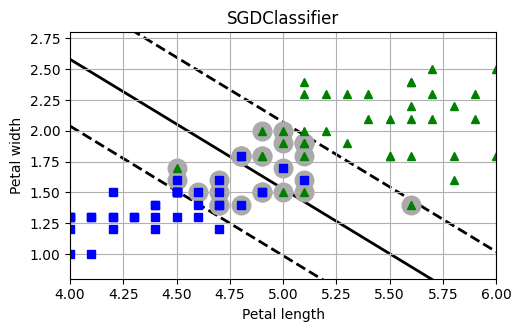

In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3,
						random_state=42)
sgd_clf.fit(X, y)

m = len(X)
t = np.array(y).reshape(-1, 1) * 2 - 1  # -1 if y == 0, or +1 if y == 1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5, 3.2))
plt.plot(X[:, 0][yr == 1], X[:, 1][yr == 1], "g^")
plt.plot(X[:, 0][yr == 0], X[:, 1][yr == 0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.title("SGDClassifier")
plt.axis([4, 6, 0.8, 2.8])
plt.grid()

plt.show()

### Notes and tips:

1) ***What is the fundamental idea behind the Support Vector Machine (SVM)***

The fundamental idea behind Support Vector Machines is to fit the widest possible "street" between the classes. In other words, the goal is to have the largest possible margin between the decision boundary that separates the two classes and the training instances. When performing perfectly soft margin classification, the SVM searches for a compromise between perfectly separating the two classes and having the widest possible street (a few instances may end up on the street). Another key idea is to use kernels when training on nonlinear datasets. SVMs can also be tweaked to perform linear and nonlinear regression as well as novelty detection.

2) ***What is a support vector?***

After training an SVM, a support vector is any instance located on the "street", including its border. The decision boundary is entirely determined by the support vectors. Any instance that is not a support vector (is off the street) has no influence whatsoever you could remove them, add more instances, or move them around, as long as they stay off the steer they won't affect the decision boundary. Computing the predictions with a kernelized SVM only involves the support vectors, not the whole training set.

3) ***Why is it important to scale the inputs when using SVMs?***

SVMs try to fit the largest possible "street" between the classes, so if the training set is not scaled, the SVM will tend to neglect small features

4) ***Can an SVM classifier output a confidence score when it classifies an instance? What about a probability?***

You can use the `decision_function()` method to get confidence scores. These scores represent the distance between the instance and the decision boundary. However, they cannot be directly converted into an estimation of the class probability. If you set `probability=True` when creating an `SVC`, then at the end of training it will use 5-fold cross-validation to generate out-of-sample scores for the training samples, and it will train a `LogisticRegression` model to map these scores to estimated probabilities. The `predict_proba()` and `predict_log_proba()` methods will then be available.

5) ***Should you use the primal or the dual for of the SVM problem to train a model on a training set with millions of instances and hundred of features?***

This question applies only to Linear SVMs since kernelized SVMs can only use the dual form. The computational complexity of the primal form of the SVM problem is proportional to the number of training instances $m$, while the computational complexity of the dual form is proportional to a number between $m^2$ and $m^3$. So if there are millions of instances, you should definitely use the primal form, because the dual form will be much too slow

6) ***Say you've trained an SVM classifier with an RBF kernel, but it seems to underfit the training set. Should you increase or decrease $\gamma$ (gamma)? What about $C$?***

If an SVM classifier trained with an RBF kernel underfits the training set, there might be too much regularization. To decrease it, you need to increase $\gamma$ or $C$ or both

7) ***How should you set the QP parameters ($H$, $f$, $A$ and $b$) to solve the soft margin linear SVM classifier problem using an off-the-shelf QP solver?***

Let's call the QP parameters for the hard margin problem $H^{\prime}$, $f^{\prime}$, $A^{\prime}$ and $b^{\prime}$. The QP parameters for the soft margin problem have $m$ additional parameters ($n_{p}=n+1+m$) and $m$ additional constraints ($n_{c}=2m$). They can be defined like so:
- $H$ is equal to $H^{\prime}$, plus $m$ columns of 0s on the right and $m$ rows of 0s at the bottom:

$$\mathbf{H} =
\begin{pmatrix}
\mathbf{H}' & 0 & \cdots & 0 \\
0 & 0 & \cdots & 0 \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & 0
\end{pmatrix}$$
- $f$ is equal to $f^{\prime}$ with $m$ additional elements, all equal to the value of the hyperparameter $C$.
- $b$ is equal to $b^{\prime}$ with $m$ additional elements, all equal to 0
- $A$ is equal to $A^{\prime}$, with an extra $m\times m$ identity matrix $I_{m}$ appended to the right, $-I_{m}$ just below it, and the rest filled with 0s:
$$
\mathbf{A}=\left(\begin{array}{cc}
\mathbf{A}^{\prime} & \mathbf{I}_m \\
\mathbf{0} & -\mathbf{I}_m
\end{array}\right)
$$

8) ***Train a LinearSVC on a linearly separable dataset. Then train a SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model***

In [14]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [15]:
C = 5
alpha = 0.05

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf = LinearSVC(loss="hinge", C=C, dual=True, random_state=42).fit(X_scaled, y)
svc_clf = SVC(kernel="linear", C=C).fit(X_scaled, y)
sgd_clf = SGDClassifier(alpha=alpha, random_state=42).fit(X_scaled, y)

In [16]:
def compute_decision_boundary(model):
	w = -model.coef_[0, 0] / model.coef_[0, 1]
	b = -model.intercept_[0] / model.coef_[0, 1]
	return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

In [17]:
lin_line = compute_decision_boundary(lin_clf)
svc_line = compute_decision_boundary(svc_clf)
sgd_line = compute_decision_boundary(sgd_clf)

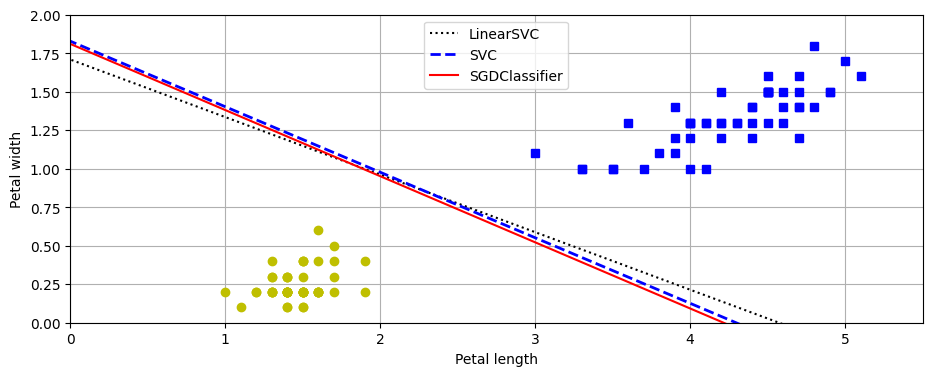

In [18]:
plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k:", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "bs")  # label="Iris versicolor"
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "yo")  # label="Iris setosa"
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper center")
plt.axis([0, 5.5, 0, 2])
plt.grid()

plt.show()

9) ***Train an SVM classifier on the MNIST dataset. Since SVM classifier are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?***

In [20]:
# This cell takes too much time (depending on your machine)

# from sklearn.datasets import fetch_openml
#
# mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)
#
# X = mnist["data"]
# y = mnist["target"].astype(np.uint8)
#
# X_train = X[:60000]
# y_train = y[:60000]
# X_test = X[60000:]
# y_test = y[60000:]
#
# lin_clf = LinearSVC(random_state=42)
# lin_clf.fit(X_train, y_train, verbose=4)
#
# from sklearn.metrics import accuracy_score
#
# y_pred = lin_clf.predict(X_train)
# print(accuracy_score(y_train, y_pred))
#
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
# X_test_scaled = scaler.fit_transform(X_test.astype(np.float32))
#
# lin_clf = LinearSVC(random_state=42)
# lin_clf.fit(X_train_scaled, y_train)
#
# y_pred = lin_clf.predict(X_train_scaled)
# print(accuracy_score(y_train, y_pred))
#
# svm_clf = SVC(gamma="scale")
# svm_clf.fit(X_train_scaled[:10000], y_train[:10000])
# y_pred = svm_clf.predict(X_train_scaled)
# print(accuracy_score(y_train, y_pred))
#
# from sklearn.model_selection import RandomizedSearchCV
# from scipy.stats import reciprocal, uniform
#
# param_distribution = {
# 	"gamma": reciprocal(0.001, 0.1),
# 	"C": uniform(1, 3)
# }
# rnd_search_cv = RandomizedSearchCV(svm_clf, param_distribution, n_iter=10, verbose=2, cv=3)
# rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])
# print(rnd_search_cv.best_estimator_)
# print(rnd_search_cv.best_score_)
#
# rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)
# y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
# print(accuracy_score(y_train, y_pred))
#
# y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
# print(accuracy_score(y_test, y_pred))

10) ***Train an SVM classifier on the Wine dataset, which you can load using sklearn. The goal is to train a classification model capable of prediction the cultivator based on the wine's chemical analysis. Since SVM classifier are binary classifier, you will need to use one-versus-all to classify all 3 classes. What accuracy can you reach?***

In [22]:
from sklearn.datasets import load_wine

wine = load_wine(as_frame=True)
print(wine.DESCR)

.. _wine_dataset:

Wine recognition dataset
------------------------

**Data Set Characteristics:**

:Number of Instances: 178
:Number of Attributes: 13 numeric, predictive attributes and the class
:Attribute Information:
    - Alcohol
    - Malic acid
    - Ash
    - Alcalinity of ash
    - Magnesium
    - Total phenols
    - Flavanoids
    - Nonflavanoid phenols
    - Proanthocyanins
    - Color intensity
    - Hue
    - OD280/OD315 of diluted wines
    - Proline
    - class:
        - class_0
        - class_1
        - class_2

:Summary Statistics:

============================= ==== ===== ======= =====
                                Min   Max   Mean     SD
============================= ==== ===== ======= =====
Alcohol:                      11.0  14.8    13.0   0.8
Malic Acid:                   0.74  5.80    2.34  1.12
Ash:                          1.36  3.23    2.36  0.27
Alcalinity of Ash:            10.6  30.0    19.5   3.3
Magnesium:                    70.0 162.0    99.7  14.3

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, random_state=42)

In [24]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
100,12.08,2.08,1.70,17.5,97.0,2.23,2.17,0.26,1.40,3.30,1.27,2.96,710.0
122,12.42,4.43,2.73,26.5,102.0,2.20,2.13,0.43,1.71,2.08,0.92,3.12,365.0
154,12.58,1.29,2.10,20.0,103.0,1.48,0.58,0.53,1.40,7.60,0.58,1.55,640.0
51,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0


In [25]:
y_train.head()

2      0
100    1
122    1
154    2
51     0
Name: target, dtype: int64

In [26]:
lin_clf = LinearSVC(random_state=42, dual=True)
lin_clf.fit(X_train, y_train)

C:\Users\Aleksandre\Documents\GitHub\python-hands-on-machine-learning\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,penalty,'l2'
,loss,'squared_hinge'
,dual,True
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,42


In [27]:
lin_clf = LinearSVC(max_iter=1000000, dual=True, random_state=42)
lin_clf.fit(X_train, y_train)

C:\Users\Aleksandre\Documents\GitHub\python-hands-on-machine-learning\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,penalty,'l2'
,loss,'squared_hinge'
,dual,True
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,42


In [28]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

C:\Users\Aleksandre\Documents\GitHub\python-hands-on-machine-learning\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Aleksandre\Documents\GitHub\python-hands-on-machine-learning\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Aleksandre\Documents\GitHub\python-hands-on-machine-learning\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Aleksandre\Documents\GitHub\python-hands-on-machine-learning\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Aleksandre\Documents\GitHub\python-hands-on-machine-learning\.venv\Lib\site-packages\sklearn\svm\_b

np.float64(0.90997150997151)

In [29]:
lin_clf = make_pipeline(
	StandardScaler(),
	LinearSVC(dual=True, random_state=42)
)
lin_clf.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('linearsvc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,loss,'squared_hinge'
,dual,True
,tol,0.0001


In [30]:
cross_val_score(lin_clf, X_train, y_train).mean()

np.float64(0.9774928774928775)

In [31]:
svm_clf = make_pipeline(
	StandardScaler(),
	SVC(random_state=42)
)
cross_val_score(svm_clf, X_train, y_train).mean()

np.float64(0.9698005698005698)

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

param_distribution = {
	"svc__gamma": loguniform(0.001, 0.1),
	"svc__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distribution, n_iter=100, cv=5, random_state=42)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

,steps,"[('standardscaler', ...), ('svc', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,np.float64(9.925589984899778)
,kernel,'rbf'
,degree,3
,gamma,np.float64(0....6281799901188)


In [33]:
rnd_search_cv.best_score_

np.float64(0.9925925925925926)

In [34]:
rnd_search_cv.score(X_test, y_test)

0.9777777777777777

11) ***Train and fine-tune an SVM regressor on the California housing dataset.***

In [36]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing.data
y = housing.target

In [38]:
from sklearn.svm import LinearSVR

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_svr = make_pipeline(
	StandardScaler(),
	LinearSVR(dual=True, random_state=42)
)
lin_svr.fit(X_train, y_train)

C:\Users\Aleksandre\Documents\GitHub\python-hands-on-machine-learning\.venv\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,steps,"[('standardscaler', ...), ('linearsvr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'


In [39]:
lin_svr = make_pipeline(
	StandardScaler(),
	LinearSVR(max_iter=5000, dual=True, random_state=42)
)
lin_svr.fit(X_train, y_train)

,steps,"[('standardscaler', ...), ('linearsvr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,epsilon,0.0
,tol,0.0001
,C,1.0
,loss,'epsilon_insensitive'


In [45]:
from sklearn.metrics import root_mean_squared_error

y_pred = lin_svr.predict(X_train)
rmse = root_mean_squared_error(y_train, y_pred)
rmse

0.979565447829459

In [46]:
from sklearn.svm import SVR

svm_reg = make_pipeline(StandardScaler(), SVR())

param_distribution = {
	"svr__gamma": loguniform(0.001, 0.1),
	"svr__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_reg, param_distribution, n_iter=100, cv=3, random_state=42)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])

,estimator,"Pipeline(step...svr', SVR())])"
,param_distributions,"{'svr__C': <scipy.stats....0016FCBDC0510>, 'svr__gamma': <scipy.stats....0016FCDEF1650>}"
,n_iter,100
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [47]:
rnd_search_cv.best_estimator_

,steps,"[('standardscaler', ...), ('svr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,kernel,'rbf'
,degree,3
,gamma,np.float64(0....1408196485979)
,coef0,0.0


In [48]:
-cross_val_score(rnd_search_cv.best_estimator_, X_train,y_train,scoring="neg_root_mean_squared_error")

array([0.58835648, 0.57468589, 0.58085278, 0.57109886, 0.59853029])

In [50]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test)
rmse = root_mean_squared_error(y_test,y_pred)
rmse

0.5854732265172243